# Initial Set-Up

In [1]:
import pickle
import pandas as pd
import matplotlib
import os
import re

import collections
import datetime
import time

import geopandas as gpd

import numpy as np

import rasterio

from difflib import get_close_matches

from fuzzywuzzy import process
from fuzzywuzzy import fuzz

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import geopandas as gpd

import seaborn as sns

import numpy as np

import scipy

from matplotlib.colors import LogNorm

from sklearn import preprocessing

import dask.dataframe as dd



/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Weather Data
## *this is how we process the cmip6Data


In [ ]:
import netCDF4 as nc
import xarray as xr

In [ ]:
file = '../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/pr/pr_day_MIROC6_historical_r7i1p1f1_gn_20100101-20141231.nc'
data = xr.open_dataset(file)   #  nc.Dataset(file)

In [ ]:
data

In [ ]:
geoHQ = gpd.GeoDataFrame(
    allIG,
    geometry=gpd.points_from_xy(
        allIG["longitude"],
        allIG["latitude"],
    ),
    crs={"init":"EPSG:4326"},
)

In [ ]:
geoHQ['longitude']

In [ ]:
one_point = data["pr"].sel(lat=50, lon=50)

In [ ]:
pd.DataFrame(test.temperature[test.year == 2010]).plot()

Now go through and make this iterable for the entire list.

In [ ]:
i = 0
data.pr.sel(allIG.iloc[0,:], method='nearest')

In [ ]:
hqPost2010 = geoHQ[geoHQ.archive_version_year > 2010].reset_index()

In [ ]:
start = time.time()



tempsList = list()
for i in range(0,hqPost2010.shape[0]):
    nearbyTemps = temps.sel(hqPost2010.loc[i,['latitude','longitude']], method='nearest')
    
    tempsList.append(list(np.array(nearbyTemps.temperature[nearbyTemps.year == hqPost2010.archive_version_year[i]])))

    if (i%100 == 0):
        print(i)
    
print(time.time() - start)






In [ ]:
outfile =  'data/hqDailyTemperatures.pkl'
with open(outfile, 'wb') as pickle_file:
    pickle.dump(tempsList, pickle_file)

# Now let's do the percentiles

In [2]:
baselineName = '../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/mirocHQs_198199.csv'
baseline = pd.read_csv(baselineName)

In [3]:
baseline.head()

,zipcode,variable,value,quarter
0,44146,pr_hist,5.603128e-06,Q1
1,85260,pr_hist,4.505838e-18,Q1
2,8876,pr_hist,3.638395e-08,Q1
3,60411,pr_hist,1.171563e-05,Q1
4,74102,pr_hist,4.505838e-18,Q1


In [4]:
quants   = baseline.groupby(['zipcode','variable','quarter']).quantile(.95).reset_index()
quants.rename(columns = {'value': 'quantCutoff'}, inplace = True)


In [5]:
quants.head()

,zipcode,variable,quarter,quantCutoff
0,1226,pr_hist,Q1,0.000215
1,1226,pr_hist,Q2,0.000275
2,1226,pr_hist,Q3,0.000249
3,1226,pr_hist,Q4,0.000224
4,1226,tasmax_hist,Q1,286.183535


And apply them to the next period.

In [6]:
nextPeriodName = '../../../../../../../Volumes/backup2/dissData/cmip6Data/proj/mirocHQs_202040.csv'
nextPeriod = pd.read_csv(nextPeriodName)

In [7]:
nextPeriod.head()

,zipcode,latitude,longitude,s,variable,value,year,quarter
0,44146,41.41278,-81.50616,1,pr_hist,5.541186e-05,2020,Q1
1,85260,33.61963,-111.90171,1,pr_hist,4.853382e-17,2020,Q1
2,8876,40.59778,-74.69065,1,pr_hist,4.139848e-08,2020,Q1
3,60411,41.52176,-87.61784,1,pr_hist,1.024405e-04,2020,Q1
4,74102,36.15089,-95.99398,1,pr_hist,2.608104e-06,2020,Q1


In [8]:
nextPeriod = nextPeriod.merge(quants)
nextPeriod.head()

,zipcode,latitude,longitude,s,variable,value,year,quarter,quantCutoff
0,44146,41.41278,-81.50616,1,pr_hist,0.000055,2020,Q1,0.000161
1,44146,41.41371,-81.50582,1,pr_hist,0.000055,2020,Q1,0.000161
2,44146,41.41278,-81.50616,1,pr_hist,0.000002,2020,Q1,0.000161
3,44146,41.41371,-81.50582,1,pr_hist,0.000002,2020,Q1,0.000161
4,44146,41.41278,-81.50616,1,pr_hist,0.000003,2020,Q1,0.000161


In [9]:
nextPeriod['extreme'] = 1*(nextPeriod.value > nextPeriod.quantCutoff)

In [10]:
quarterlyExtremes = nextPeriod[['variable','year','quarter','zipcode','extreme','latitude','longitude']].\
    groupby(['variable','year','quarter','zipcode','latitude','longitude']).sum().reset_index()

In [11]:
quarterlyExtremes['extremesNormd'] = quarterlyExtremes.extreme - 4.5

In [12]:
quarterlyExtremes.head()

,variable,year,quarter,zipcode,latitude,longitude,extreme,extremesNormd
0,pr_hist,2020,Q1,1226,42.47064,-73.17891,8,3.5
1,pr_hist,2020,Q1,1434,42.53712,-71.62612,5,0.5
2,pr_hist,2020,Q1,1434,42.53716,-71.62616,5,0.5
3,pr_hist,2020,Q1,1460,42.51834,-71.51949,5,0.5
4,pr_hist,2020,Q1,1473,42.55072,-71.90098,5,0.5


In [13]:
quarterlyExtremesMean = quarterlyExtremes[['variable','quarter','zipcode','latitude','longitude','extreme']].\
    groupby(['variable','quarter','zipcode','latitude','longitude']).mean().reset_index()

In [14]:
quarterlyExtremesMean.to_csv("../../data/companyData/quarterlyExtremesMean.csv")


In [3]:
quarterlyExtremesMean = pd.read_csv("../../data/companyData/quarterlyExtremesMean.csv").drop(columns = {'Unnamed: 0'})

In [5]:
quarterlyExtremesMean.head()

,variable,quarter,zipcode,latitude,longitude,extreme
0,pr_hist,Q1,1226,42.47064,-73.17891,5.428571
1,pr_hist,Q1,1434,42.53712,-71.62612,5.476190
2,pr_hist,Q1,1434,42.53716,-71.62616,5.476190
3,pr_hist,Q1,1460,42.51834,-71.51949,5.476190
4,pr_hist,Q1,1473,42.55072,-71.90098,5.476190


In [46]:
# we might have multiple records from within the same zipcode
quarterlyExtremesMean = quarterlyExtremes[['variable','quarter','zipcode','extreme']].\
    groupby(['variable','quarter','zipcode']).mean().reset_index()

# .groupby(['variable','quarter','zipcode']).mean().reset_index()


variable
pr_hist        AxesSubplot(0.125,0.125;0.775x0.755)
tasmax_hist    AxesSubplot(0.125,0.125;0.775x0.755)
Name: extreme, dtype: object

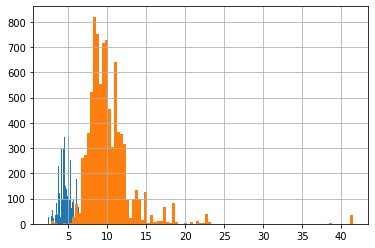

In [50]:
quarterlyExtremesMean.groupby('variable').extreme.hist(bins = 100)

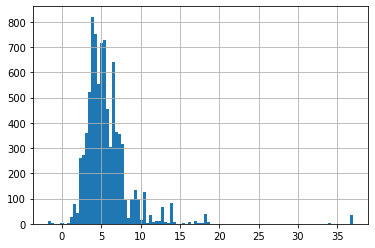

In [54]:
(quarterlyExtremesMean[quarterlyExtremesMean.variable == 'tasmax_hist'].extreme - 4.5).hist(bins = 100)

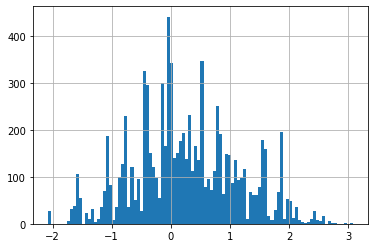

In [53]:
(quarterlyExtremesMean[quarterlyExtremesMean.variable == 'pr_hist'].extreme - 4.5).hist(bins = 100)

In [57]:
sum(quarterlyExtremesMean[quarterlyExtremesMean.variable == 'pr_hist'].extreme > 4.5)/quarterlyExtremesMean[quarterlyExtremesMean.variable == 'pr_hist'].shape[0]

0.5886075949367089

In [58]:
sum(quarterlyExtremesMean[quarterlyExtremesMean.variable == 'tasmax_hist'].\
    extreme > 4.5)/quarterlyExtremesMean[quarterlyExtremesMean.variable == 'tasmax_hist'].shape[0]

0.9983591186122832